<font color=red>注：此处是文档第145页</font>

# 空间变换器网络
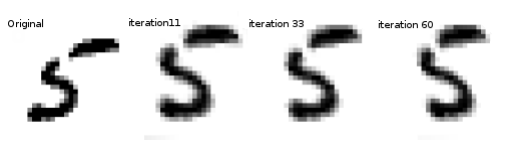

在本教程中，您将学习如何使用称为空间变换器网络的视觉注意机制来扩充您的网络。你可以在 [DeepMind paper](https://arxiv.org/abs/1506.02025) 阅读更多有关空间变换器网络的内容。

空间变换器网络是对任何空间变换的差异化关注的概括。空间变换器网络（简称STN）允许神经网络学习如何在输入图像上执行空间变换， 以增强模型的几何不变性。例如，它可以裁剪感兴趣的区域，缩放并校正图像的方向。而这可能是一种有用的机制，因为CNN对于旋转和缩放以及更一般的仿射变换并不是不变的。

关于`STN`的最棒的事情之一是能够简单地将其插入任何现有的CNN，而且只需很少的修改。

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
plt.ion() # 交互模式

## 1.加载数据
在这篇文章中，我们尝试了经典的 `MNIST` 数据集。使用标准卷积网络增强空间变换器网络。

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_dir = "../../data/"
# 训练数据集
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        root=root_dir, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])), batch_size=64, shuffle=True, num_workers=4)

# 测试数据集
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        root=root_dir, train=False, 
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])), batch_size=64, shuffle=True, num_workers=4)

## 2.什么是空间变换器网络？
空间变换器网络归结为三个主要组成部分：
- 本地网络（Localisation Network）是常规CNN，其对变换参数进行回归。不会从该数据集中明确地学习转换，而是网络自动学习增强全局准确性的空间变换。
- 网格生成器(Grid Genator)在输入图像中生成与输出图像中的每个像素相对应的坐标网格。
- 采样器（Sampler）使用变换的参数并将其应用于输入图像。
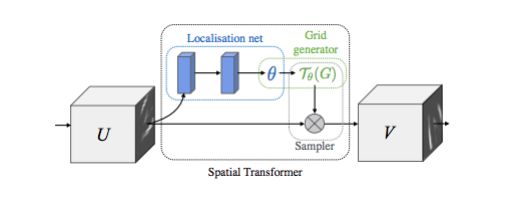

<font color='red'>注意：</font>我们使用最新版本的Pytorch，它应该包含`affine_grid`和`grid_sample`模块。